In [379]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [380]:
data = pd.read_csv("vodafone_age_subset.csv")

In [381]:
data.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21000 entries, 0 to 20999
Data columns (total 116 columns):
 #    Column                       Non-Null Count  Dtype  
---   ------                       --------------  -----  
 0    CALCULATION_METHOD_ID        21000 non-null  int64  
 1    calls_count_in_weekdays      21000 non-null  float64
 2    calls_duration_in_weekdays   21000 non-null  float64
 3    calls_count_out_weekdays     21000 non-null  float64
 4    calls_duration_out_weekdays  21000 non-null  float64
 5    calls_count_in_weekends      21000 non-null  float64
 6    calls_duration_in_weekends   21000 non-null  float64
 7    calls_count_out_weekends     21000 non-null  float64
 8    calls_duration_out_weekends  21000 non-null  float64
 9    DATA_VOLUME_WEEKDAYS         21000 non-null  float64
 10   DATA_VOLUME_WEEKENDS         21000 non-null  float64
 11   LAT_HOME                     21000 non-null  float64
 12   LON_HOME                     21000 non-null  float64
 13  

## 1. Data explore

Alright, we can see that the dataset does not contain missing data, which is really good news for us

Now, let's look at the distributions of our numeric columns

In [382]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
CALCULATION_METHOD_ID,21000.0,1.504190,0.499994,1.0,1.000,2.0000,2.00000,2.0000
calls_count_in_weekdays,21000.0,5.024132,9.872541,0.0,1.220,3.3500,6.70000,742.6100
calls_duration_in_weekdays,21000.0,11.166896,13.998677,0.0,2.411,7.4855,15.79525,818.3590
calls_count_out_weekdays,21000.0,5.250357,11.382722,0.0,1.000,3.2600,6.87000,680.0900
calls_duration_out_weekdays,21000.0,12.010912,15.876250,0.0,2.021,7.4220,16.77200,770.0130
...,...,...,...,...,...,...,...,...
jabber_volume,21000.0,0.001798,0.068234,0.0,0.000,0.0000,0.00000,6.0645
jabber_count,21000.0,0.050738,3.514625,0.0,0.000,0.0000,0.00000,498.5500
telegram_volume,21000.0,0.003654,0.140272,0.0,0.000,0.0000,0.00000,14.5498
telegram_count,21000.0,0.126115,3.443548,0.0,0.000,0.0000,0.00000,308.6100


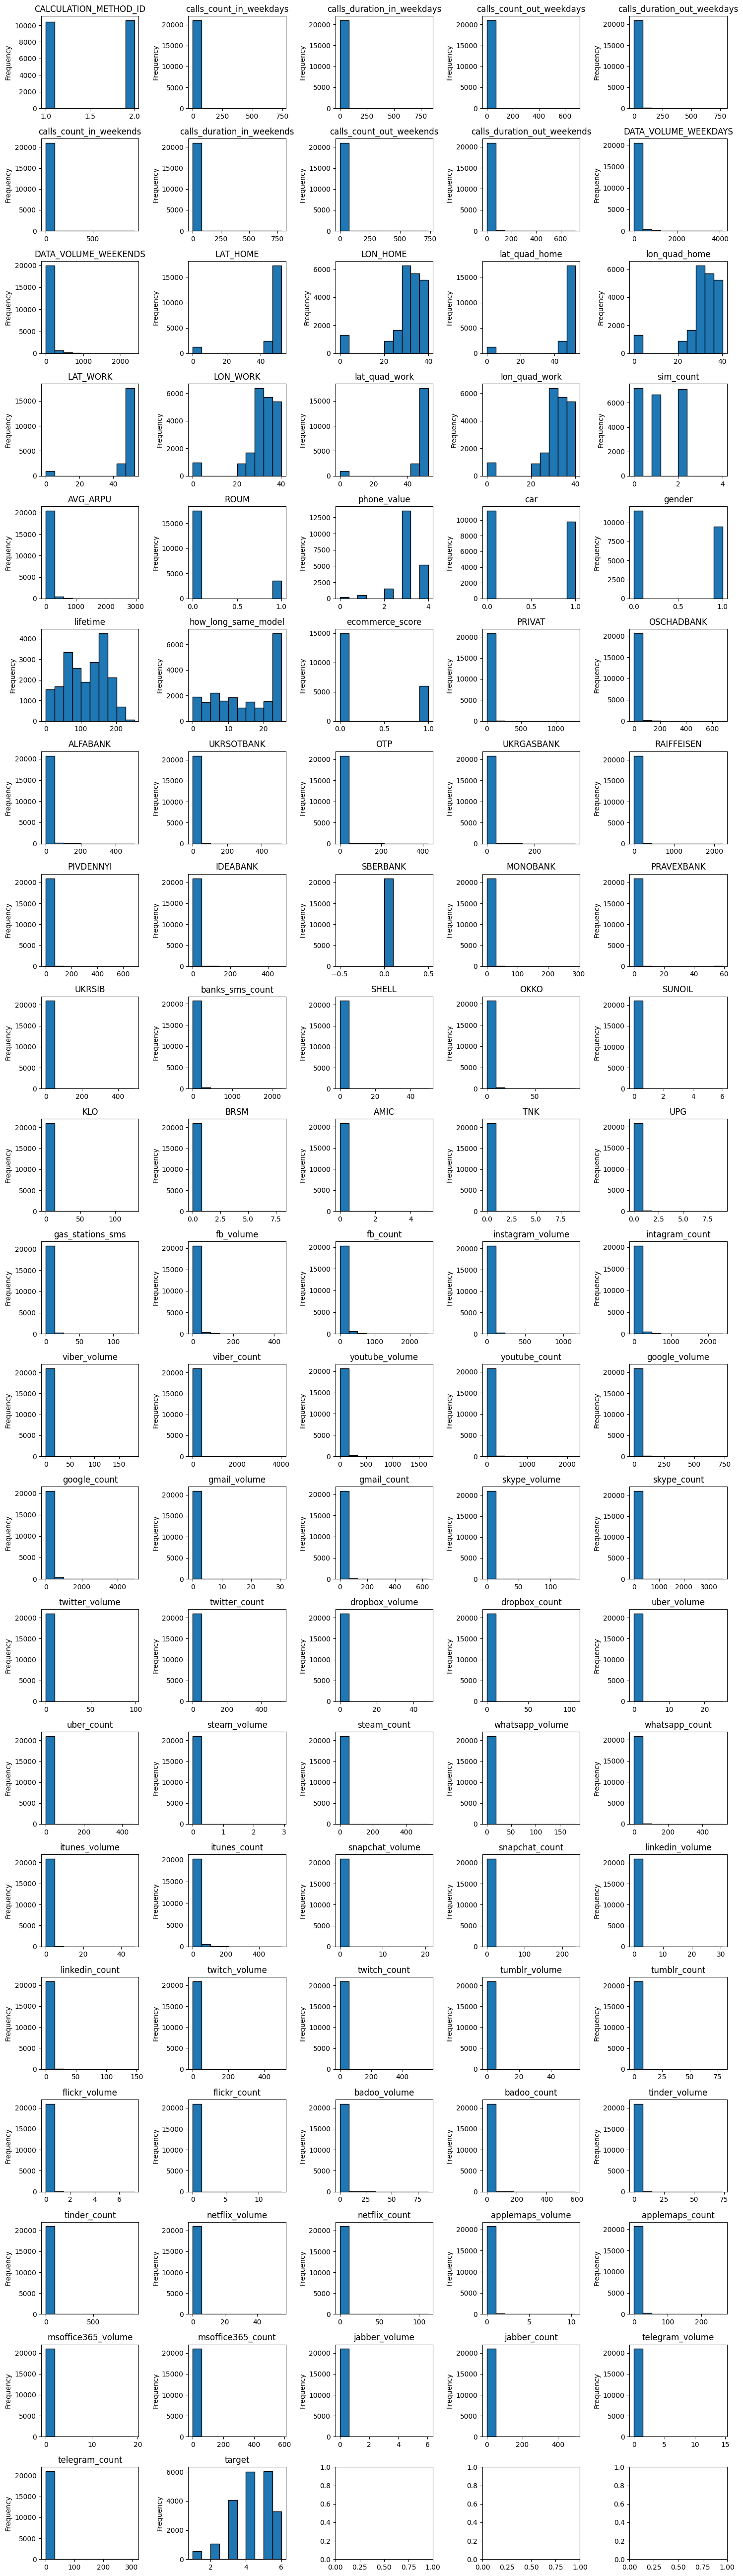

In [383]:
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns

fig, axes = plt.subplots(nrows=len(numerical_columns) // 5 + 1, ncols=5, figsize=(15,  (len(numerical_columns) // 4 + 1) * 2))

axes = axes.flatten()

for i, column in enumerate(numerical_columns):
    ax = axes[i]
    data[column].plot(kind='hist', ax=ax, title=column, edgecolor='black')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()


Let's also look at the distribution of our target

<Axes: xlabel='target'>

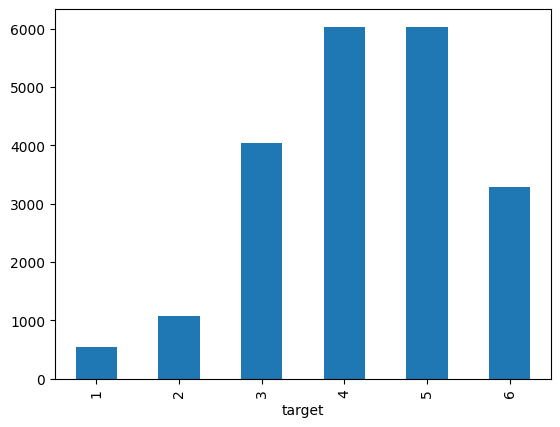

In [384]:
data['target'].value_counts().sort_index().plot(kind="bar")

It's aproximately normal

So, our dataset is a set of different kind of information for some user, and using this data, we need to predict their age group

We can also say that target is categorical and we have classification problem.

Let's also look at the column correlation, as this can provide us with information about which columns can we delete to optimize our model training

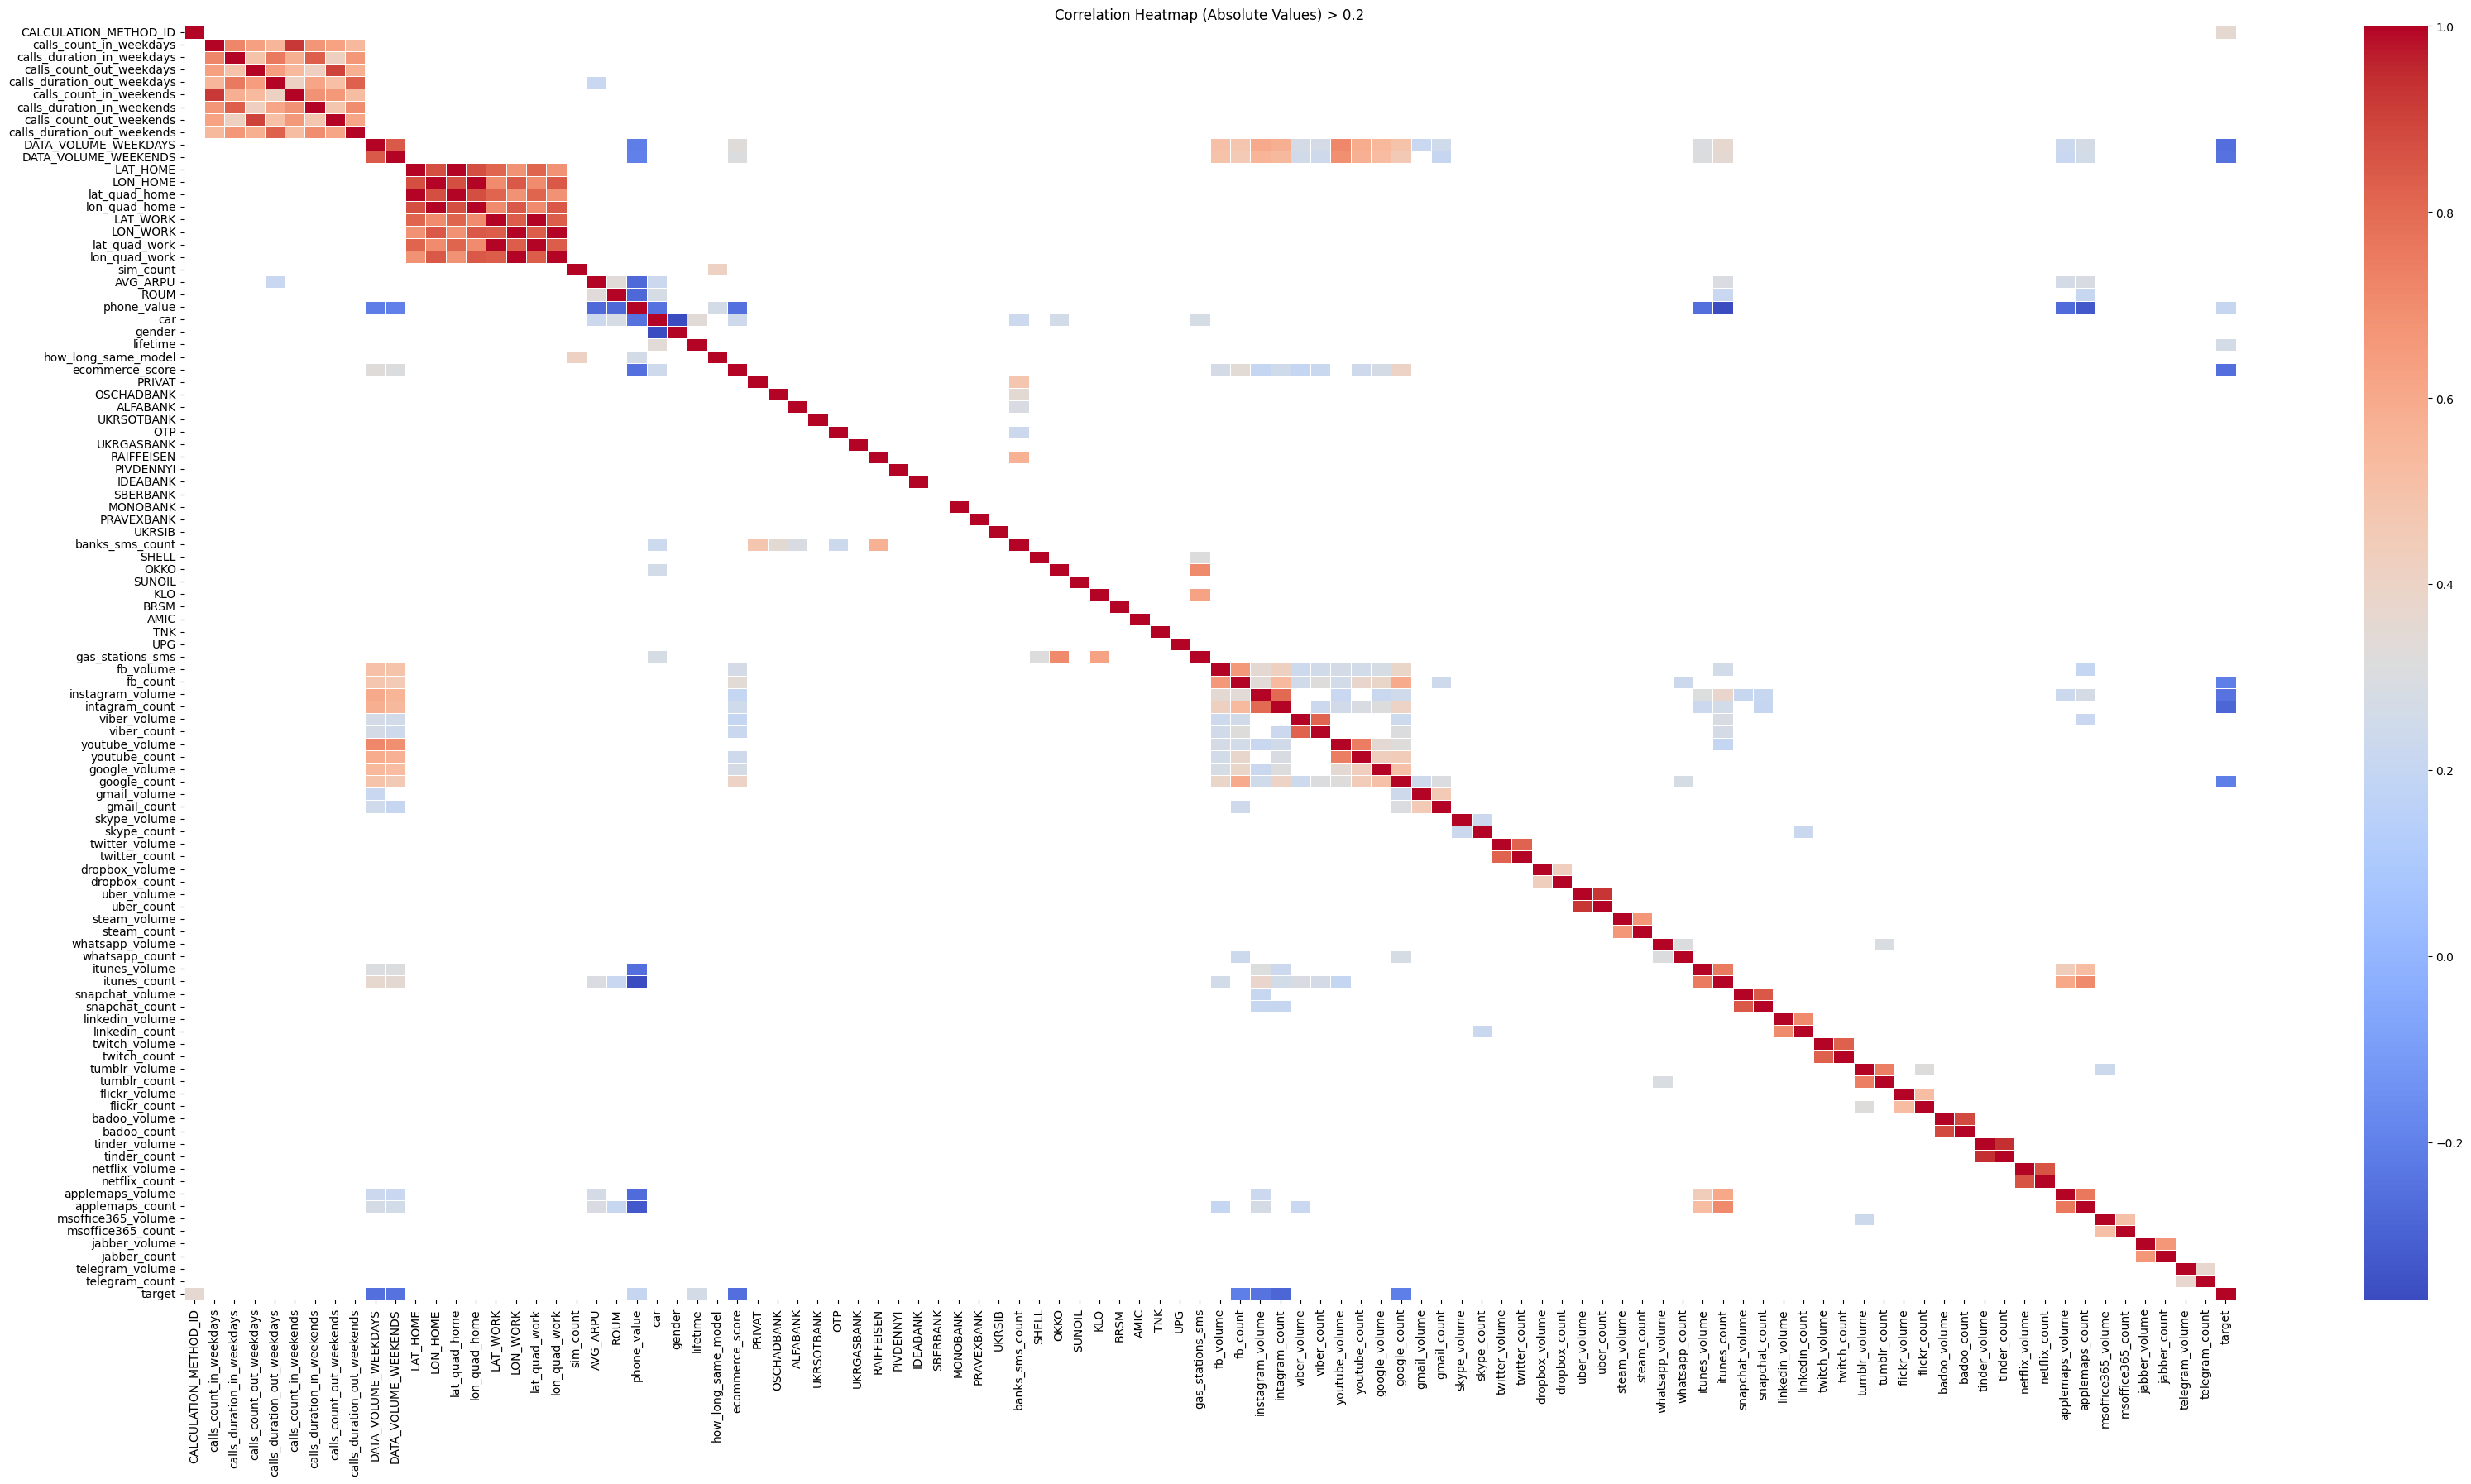

In [385]:
import seaborn as sns
numerical_columns = data.select_dtypes(include='number')
correlation_matrix = numerical_columns.corr()

mask = correlation_matrix.abs() > 0.2

plt.figure(figsize=(40, 20))
sns.heatmap(correlation_matrix[mask], cmap='coolwarm', linewidths=.5)
plt.title('Correlation Heatmap (Absolute Values) > 0.2')
plt.show()

We see, that the correlation between this columns is high, but these columns will likely be reduced during pca, so it's ok for us
Let's now look at our coordinate columns


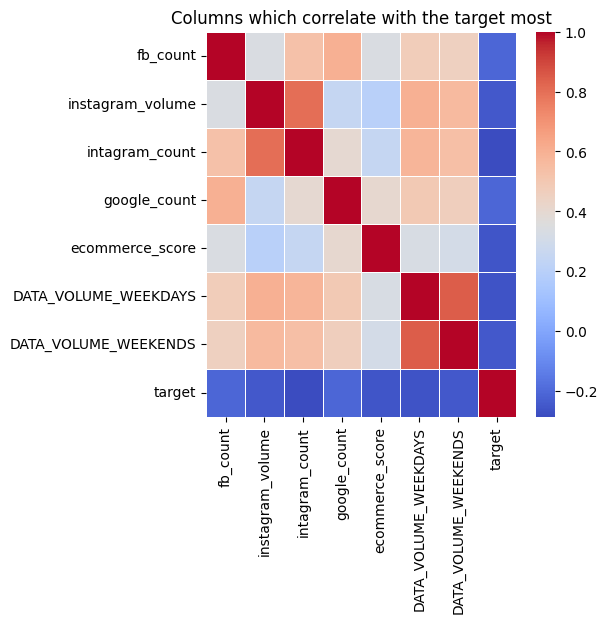

In [386]:
cols = ["fb_count", 
        "instagram_volume", 
        "intagram_count", 
        "google_count", 
        "ecommerce_score",
        "DATA_VOLUME_WEEKDAYS",
        "DATA_VOLUME_WEEKENDS",
        "target"]
correlation_matrix = data[cols].corr()

plt.figure(figsize=(5,5))
sns.heatmap(correlation_matrix, cmap='coolwarm', linewidths=.5)
plt.title('Columns which correlate with the target most')
plt.show()

## 2. Preprocessing

### Deleteting rows

Now, let's look at our string columns, to see, if we need to somehow transform them or not

In [318]:
cols = ["Oblast_post_HOME","Raion_post_HOME", "City_post_HOME", "Oblast_post_WORK", "Raion_post_WORK", "City_post_WORK"]
for i in cols:
  print(f"{i}:")
  print(data[i].value_counts())
  print("\n\n\n")

Oblast_post_HOME:
Oblast_post_HOME
Київ                    3041
Харківська              2132
Дніпропетровська        1640
0                       1295
Краматорська філія      1094
Запорізька              1073
Київська                1065
Одеська                 1062
Луганська                922
Полтавська               873
Херсонська               838
Донецька                 747
Сумська                  639
Львівська                482
Миколаївська             456
Волинська                452
Кіровоградська           446
Закарпатська             430
Івано-Франківська        405
Чернівецька              385
Чернігівська             331
Сєвєродонецька філія     326
Черкаська                198
Рівненська               182
Вінницька                118
Житомирська              110
Тернопільська            104
Криворізька філія         85
Хмельницька               69
Name: count, dtype: int64




Raion_post_HOME:
Raion_post_HOME
Київ             3041
Харків           1498
0                

Now, we will delete 0 values from these object columns, because they don't contain any information that we might use

In [319]:
data = data[data["Oblast_post_HOME"] != "0"]
data = data[data["Oblast_post_WORK"] != "0"]

In [320]:
cols = ["Oblast_post_HOME","Raion_post_HOME", "City_post_HOME", "Oblast_post_WORK", "Raion_post_WORK", "City_post_WORK"]
for i in cols:
  print(f"{i}:")
  print(data[i].value_counts())
  print("\n\n\n")

Oblast_post_HOME:
Oblast_post_HOME
Київ                    3032
Харківська              2130
Дніпропетровська        1639
Краматорська філія      1091
Запорізька              1070
Київська                1063
Одеська                 1060
Луганська                920
Полтавська               872
Херсонська               837
Донецька                 742
Сумська                  638
Львівська                481
Миколаївська             455
Волинська                452
Кіровоградська           446
Закарпатська             429
Івано-Франківська        403
Чернівецька              383
Чернігівська             330
Сєвєродонецька філія     326
Черкаська                198
Рівненська               180
Вінницька                116
Житомирська              108
Тернопільська            103
Криворізька філія         84
Хмельницька               69
Name: count, dtype: int64




Raion_post_HOME:
Raion_post_HOME
Київ             3032
Харків           1496
Дніпро           1079
Одеса             760
За

Now, let's look at our next object column pack


We have zeros on device_type_rus. On documentation its mean 'tablet' for this column, so we rename value

In [321]:
data['device_type_rus'].value_counts()

device_type_rus
smartphone    14985
phone          3290
0              1382
Name: count, dtype: int64

In [322]:
data['device_type_rus'] = data['device_type_rus'].replace({'0':'tablet'})
data['device_type_rus'].value_counts()

device_type_rus
smartphone    14985
phone          3290
tablet         1382
Name: count, dtype: int64

In [323]:
cols = ["device_brand", "device_model", "software_os_vendor", "software_os_name", "software_os_version"]
for i in cols:
  print(f"{i}:")
  print(data[i].value_counts())
  print("\n\n\n")

device_brand:
device_brand
Samsung    4980
Apple      2479
Xiaomi     2452
Nokia      2345
0          1382
           ... 
Hantel        1
Tethin        1
Reeder        1
Malata        1
Hongjia       1
Name: count, Length: 171, dtype: int64




device_model:
device_model
0                    1382
Redmi 4X              411
iPhone 6S (A1688)     302
SM-J510H DS           286
SM-J320H DS           265
                     ... 
SGH-U600                1
aura 66 pro             1
K800i                   1
Impress Luck            1
LG-K350n                1
Name: count, Length: 2024, dtype: int64




software_os_vendor:
software_os_vendor
Google         11357
0               2884
Apple           2479
Nokia           1661
Samsung          720
Microsoft        223
Symbian          157
Alibaba           81
Enea              38
Mentor Grap       20
Blackberry        13
Spreadtrum        11
Mediatek          10
Palm               2
MeeGo              1
Name: count, dtype: int64




software_os_n

Here we also see zero values, and we don't know what they mean, so we will delete them

In [324]:
cols = ["device_brand", "device_model", "software_os_vendor", "software_os_name", "software_os_version"]
for i in cols:
  data = data[data[i] != "0"]

In [325]:
cols = ["device_brand", "device_model", "software_os_vendor", "software_os_name", "software_os_version"]
for i in cols:
  print(f"{i}:")
  print(data[i].value_counts())
  print("\n\n\n")

device_brand:
device_brand
Samsung         3712
Apple           2475
Xiaomi          1926
Nokia           1113
Lenovo           898
Huawei           797
Meizu            783
LG               329
Sony             323
HTC              224
Microsoft        131
Motorola         106
DooGee            99
HMD Global        97
Asus              73
SonyEricsson      60
Prestigio         42
OnePlus           39
Alcatel           34
ZTE               34
Blackview         30
Gionee            24
Oukitel           24
Giga-Byte         17
Cubot             16
Google            12
Philips           10
Acer               9
Acquisitions       7
BlackBerry         6
Nubia              6
BLU                6
E-mobile           5
TP-Link            5
Unnecto            3
Wiko               3
Kolor              3
CAT                3
Archos             2
Viewsonic          1
Leadsky            1
Arima              1
Just5              1
HomTom             1
Micromax           1
Maysunm            1
Mingren

### Deleting columns

Now lets make some categorical features to numerical using one-hot encoding. Lets see how much we have columns

In [326]:
data.shape

(13496, 116)

Let's drop the `City_post_WORK`, `Raion_post_WORK`, `Oblast_post_WORK`, `software_os_vendor`, `device_model` and `software_os_version` columns, because they can intersect in another columns

In [327]:
trash = ["Raion_post_WORK", "City_post_WORK", "Oblast_post_WORK", "software_os_vendor", "device_model", 'software_os_version']
data = data.drop(trash, axis=1)

And lets cut values `City_post_HOME` and `Raion_post_HOME` that less than 160. This number is result of experiment

In [328]:
for column in ['City_post_HOME', "Raion_post_HOME"]:
    value_counts = data[column].value_counts()

    threshold = 160
    filtered_values = value_counts[value_counts >= threshold].index

    data = data[data[column].isin(filtered_values)]

Now, let's preprocess our string columns to make them numeric

### One-hot encoding

Firstly, we will one hot encode our categorical columns

In [329]:
data = pd.get_dummies(data, columns=["Oblast_post_HOME", "City_post_HOME", "Raion_post_HOME",
                                     "device_brand", 
                                     "software_os_name", "device_type_rus"])

### Categorial variables

Then, let's encode our ordinal variables

First, lets reverse values of the most cheapest (4) and expensive (1) mobile phones

In [330]:
phone_value_dict = {
    4 : 1,
    3 : 2,
    2 : 3,
    1 : 4
}
data["phone_value"] = data["phone_value"].map(phone_value_dict)
data["phone_value"].value_counts()

phone_value
2    5942
3    1012
4     360
1     357
Name: count, dtype: int64

Second, lets make names of scoring to numerical values

In [331]:
data.SCORING.value_counts()

SCORING
HIGH_MEDIUM    2524
MEDIUM         1838
HIGH           1581
LOW            1579
VERY LOW        149
Name: count, dtype: int64

In [332]:
SCORING_dict = {
    "VERY LOW" : 1,
    "LOW" : 2,
    "MEDIUM" : 3,
    "HIGH_MEDIUM" : 4,
    "HIGH": 5
}
data["SCORING"] = data["SCORING"].map(SCORING_dict)
data["SCORING"].value_counts()

SCORING
4    2524
3    1838
5    1581
2    1579
1     149
Name: count, dtype: int64

In [333]:
data.shape

(7671, 219)

Then, let's make the CALCULATION_METHOD_ID column binary(0, 1), because currently it consists of 1 and 2

In [334]:
method_dict = {
    1 : 0,
    2 : 1
}
data["CALCULATION_METHOD_ID"] = data["CALCULATION_METHOD_ID"].map(method_dict)
data["CALCULATION_METHOD_ID"].value_counts()

CALCULATION_METHOD_ID
1    3942
0    3729
Name: count, dtype: int64

### Unque variables

In [335]:
data.user_hash.value_counts()

user_hash
8bec6ea776a602b523965f005903cc2e    1
073c57292dfb6ddbdd22df7fcb798b70    1
7dc2b1be25c605209a5b82c0748a6f26    1
bdb62a682475388238695df88e20d97e    1
207a0b3617e404616f9f14337de710a1    1
                                   ..
cc1ee8aafcbe67897197398e95f488fe    1
3bf88fdb61971ad6dee9aecd1887c1d9    1
2c387d15312e2423418b2706c93771ac    1
8de9d0363efeb5ecd417453cf78b8f8c    1
3238afdda6814586416cf6b05d287e34    1
Name: count, Length: 7671, dtype: int64

Finally, lets delete the user_hash column, because it contains unique information, and is useless for us

In [336]:
data = data.drop("user_hash", axis=1)

In [337]:
data.shape

(7671, 218)

### Standardizing

Now, let's remove the target from our main dataset

In [338]:
y = data.target
X = data.drop("target", axis=1)

Now, let's split our data in train and test datasets, standardize our data and conduct Principal Component Analysis

In [339]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=54)


In [340]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

### PCA

We need to find the number of components, which captures at least 97% of the variance, let's see it on the plot

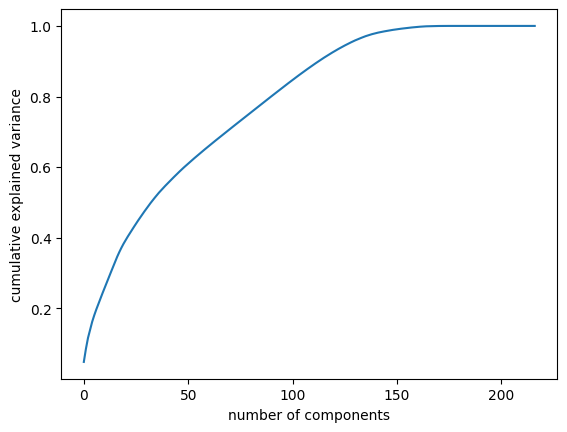

In [341]:
from sklearn.decomposition import PCA

pca = PCA().fit(X_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

We see that it takes about 140 components to capture at least 97% of the variance, let's find the exact number, by passing the 0.97 to the PCA function as a parameter

Alright, We managed to reduce our dataset almost twice, now, let's transform our data using this model

In [342]:
pca = PCA(0.97).fit(X_train)
pca.n_components_

136

In [343]:
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

## 4. Training models with default parameters

Now it's time for model training, the first model will be random forest, as it usually works good without tuning any of the hyperparameters.

We will use `n_jobs=-1` to make learning faster using all CPU cores

### Random Forest

In [344]:
from sklearn.ensemble import RandomForestClassifier

rc = RandomForestClassifier(random_state=52, n_jobs=-1)

rc.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=52)

We made list to put results and compare models

In [345]:
result = []

In [346]:
from sklearn.metrics import f1_score
y_pred = rc.predict(X_test)
result.append(f1_score(y_test, y_pred, average='weighted'))
print(f"F1_score: {f1_score(y_test, y_pred, average='weighted'):.4f}")

F1_score: 0.3643


### Logistic Regression

Let's also try logistic regressor, boosting and bagging with logistic models with defaults parameters.


In [347]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=52, max_iter=4000)
lr.fit(X_train, y_train)

LogisticRegression(max_iter=4000, random_state=52)

In [348]:
y_pred = lr.predict(X_test)
result.append(f1_score(y_test, y_pred, average='weighted'))
print(f"F1_score: {f1_score(y_test, y_pred, average='weighted'):.4f}")

F1_score: 0.4380


### Gradient Boosting

In [349]:
from sklearn.ensemble import HistGradientBoostingClassifier
hgb = HistGradientBoostingClassifier()

hgb.fit(X_train, y_train)

HistGradientBoostingClassifier()

In [350]:
y_pred = hgb.predict(X_test)
result.append(f1_score(y_test, y_pred, average='weighted'))
print(f"F1_score: {f1_score(y_test, y_pred, average='weighted'):.4f}")

F1_score: 0.3780


### Bagging

In [351]:
from sklearn.ensemble import BaggingClassifier
bglr = BaggingClassifier(LogisticRegression(random_state=52, max_iter=4000), max_samples=0.5, max_features=1.0, n_jobs=-1)

bglr.fit(X_train, y_train)

BaggingClassifier(estimator=LogisticRegression(max_iter=4000, random_state=52),
                  max_samples=0.5, n_jobs=-1)

In [352]:
y_pred = bglr.predict(X_test)
result.append(f1_score(y_test, y_pred, average='weighted'))
print(f"F1_score: {f1_score(y_test, y_pred, average='weighted'):.4f}")

F1_score: 0.4151


### Results and analisys

Now lets compare models score.

In [353]:
models = ["RandomForest", "Logistic", "Boosting", "Bagging"]

<BarContainer object of 4 artists>

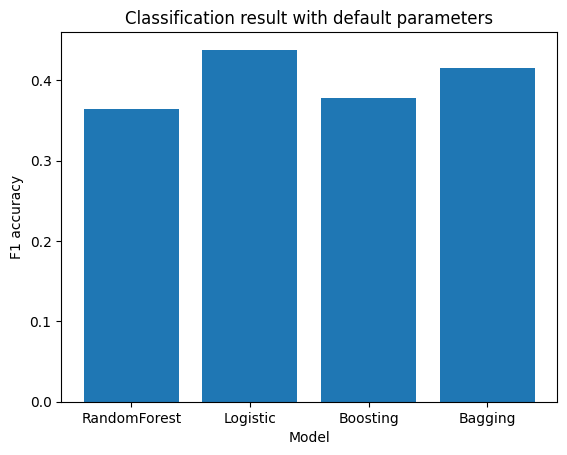

In [354]:
plt.title('Classification result with default parameters')
plt.xlabel('Model')
plt.ylabel('F1 accuracy')
plt.bar(models, result)

We can see that boosting have worst result. Logisitc regression and bagging have the best results. It may happened because we have a lot of numerical features and little categorical. 

<BarContainer object of 15 artists>

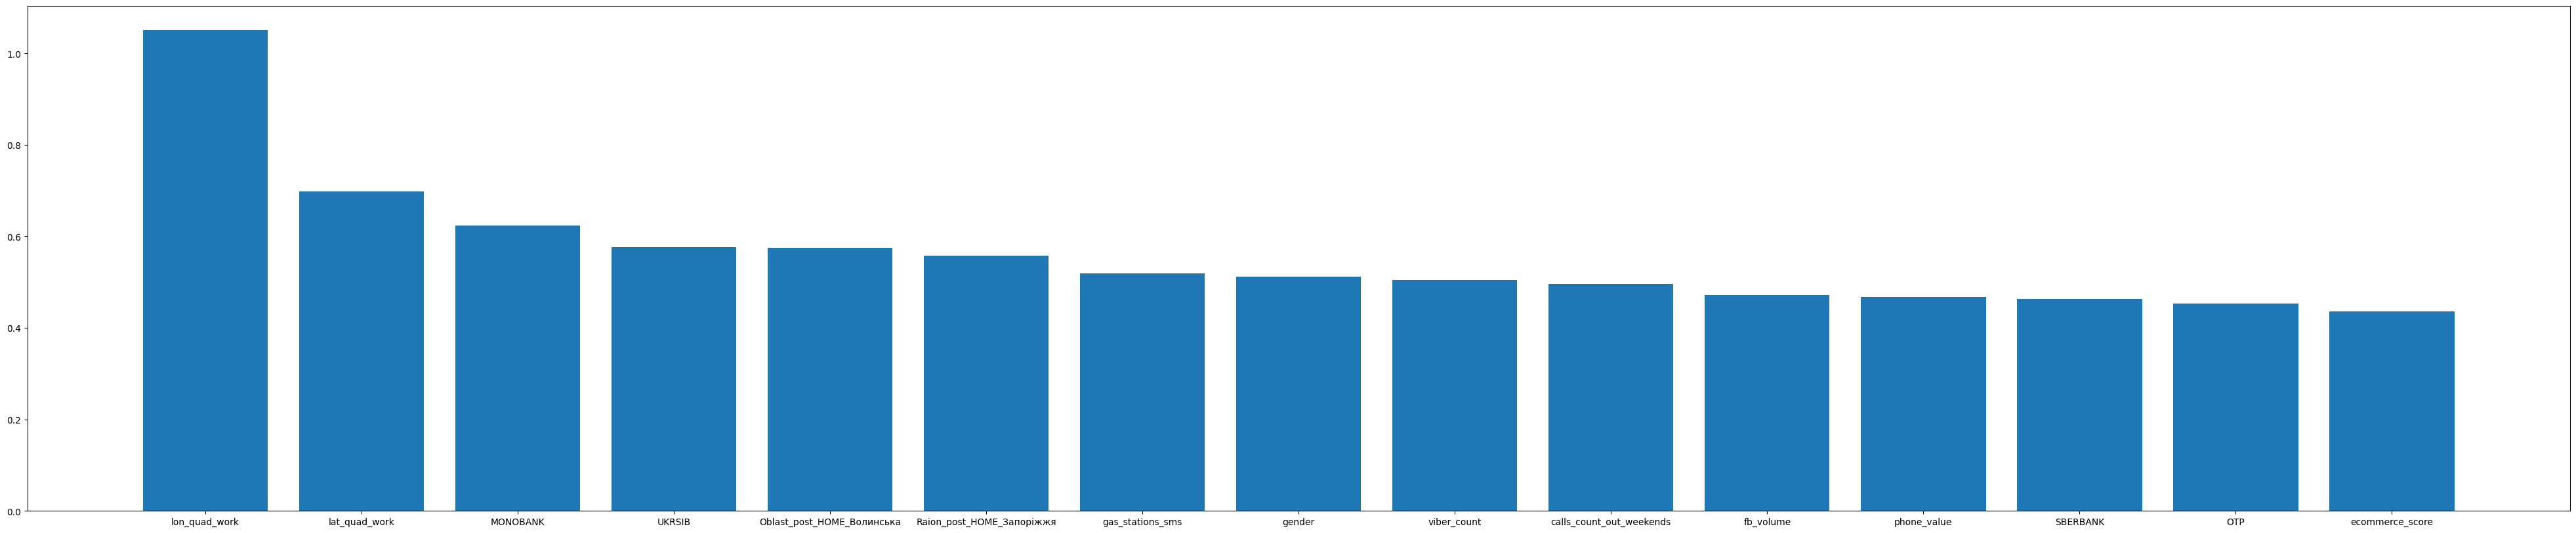

In [355]:
feature_names = data.columns[:pca.n_components_]
coefficients = np.abs(np.round(lr.coef_[0], 4))

plt.figure(figsize=(50,10))
feature_coefficients = pd.DataFrame({'feature': feature_names, 'importance': coefficients}).sort_values('importance', ascending=False)
plt.bar(feature_coefficients[:15].feature, feature_coefficients[:15].importance)

As we can see at bar, the most important coefficients is numerical.

Now lets see how look like our `confusion_matrix`.

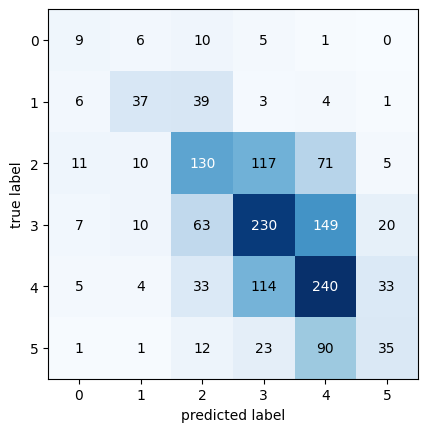

In [356]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
y_pred = lr.predict(X_test)
plot_confusion_matrix(confusion_matrix(y_test, y_pred))
plt.show()

Conclusion: models cannot predict first and second classes. We have better result for class 5, but not too much. We have good result as 50/50 for classes 2, 3, 4. It happend because of not equable distibution. The best result if 43.8% with default logistic model.

## 5. Finding parameters

At this paragraph we will find hyperparametes for our models to make better results

In [357]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

### Random Forest

In [358]:
hyperparameters = {
    'n_estimators' : np.arange(50, 800, 50),
    'max_depth': np.arange(1, 21, 2), 
    'min_samples_split': np.arange(3, 41, 2), 
    'min_samples_leaf': np.arange(1, 21, 2),
    'max_features': np.arange(1, 41, 2)
}

In [359]:
rc_CV = RandomizedSearchCV(rc, hyperparameters, scoring='f1_weighted', cv=5, random_state=52)

In [360]:
rc_CV.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=52),
                   param_distributions={'max_depth': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'max_features': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39]),
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35,
       37, 39]),
                                        'n_estimators': array([ 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650,
       700, 750])},
                   random_state=52, scoring='f1_weighted')

In [361]:
y_pred = rc_CV.best_estimator_.predict(X_test)

print("Best params for lasso:", rc_CV.best_params_)
print("Best score for lasso:", rc_CV.best_score_)

print(f"Test result: {f1_score(y_test, y_pred, average='weighted'):.4f}")

Best params for lasso: {'n_estimators': 300, 'min_samples_split': 23, 'min_samples_leaf': 5, 'max_features': 37, 'max_depth': 19}
Best score for lasso: 0.3658256736871791
Test result: 0.3724


Finding parameters helped and made better result than we have for random forest model, but it`s not the best result. 

In [364]:
from sklearn.model_selection import validation_curve

In [367]:
acur_n = validation_curve(rc_CV.best_estimator_, X_train, y_train, param_name="n_estimators", param_range=np.arange(50, 800, 50), scoring='f1_weighted', n_jobs=-1)[1]

Let`s see our validation curves.

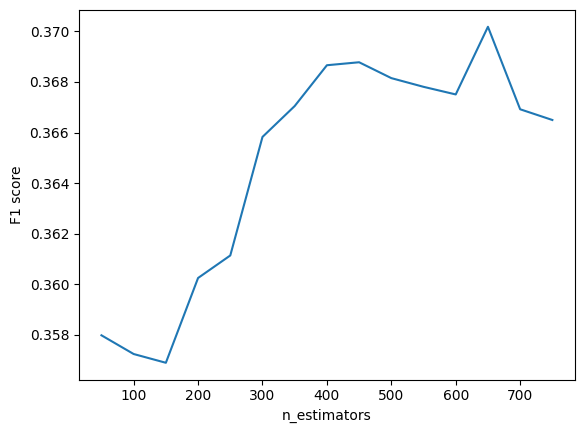

In [368]:
plt.plot(list(range(50, 800, 50)), np.mean(acur_n,  axis=1))
plt.xlabel('n_estimators')
plt.ylabel('F1 score')
plt.show()

For `max_depth`, `max_features`, `min_samples_leaf` we reached asymptote at value 10

In [369]:
acur_depth = validation_curve(rc_CV.best_estimator_, X_train, y_train, param_name="max_depth", param_range=np.arange(1, 21, 2), scoring='f1_weighted', n_jobs=-1)[1]
acur_leaf = validation_curve(rc_CV.best_estimator_, X_train, y_train, param_name="min_samples_leaf", param_range=np.arange(1, 21, 2), scoring='f1_weighted', n_jobs=-1)[1]
acur_feat = validation_curve(rc_CV.best_estimator_, X_train, y_train, param_name="max_features", param_range=np.arange(1, 41, 2), scoring='f1_weighted', n_jobs=-1)[1]

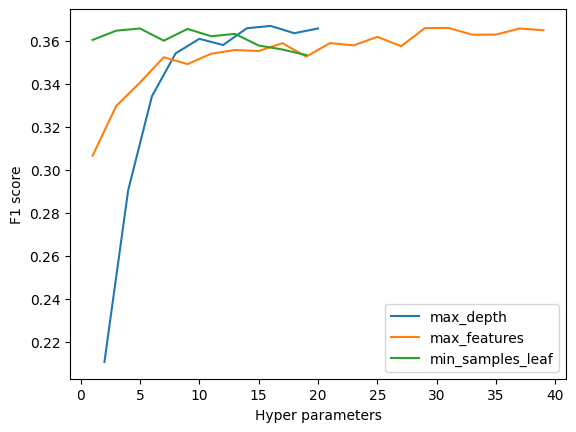

In [375]:
plt.plot(list(range(2, 21, 2)), np.mean(acur_depth,  axis=1))
plt.plot(list(range(1, 41, 2)), np.mean(acur_feat,  axis=1))
plt.plot(list(range(1, 21, 2)), np.mean(acur_leaf, axis=1))
plt.legend (('max_depth', 'max_features', 'min_samples_leaf'))
plt.xlabel('Hyper parameters')
plt.ylabel('F1 score')
plt.show()

We can see that result are worse at `min_samples_split>23`

In [376]:
acur_split = validation_curve(rc_CV.best_estimator_, X_train, y_train, param_name="min_samples_split", param_range=np.arange(1, 41, 2), scoring='f1_weighted', n_jobs=-1)[1]

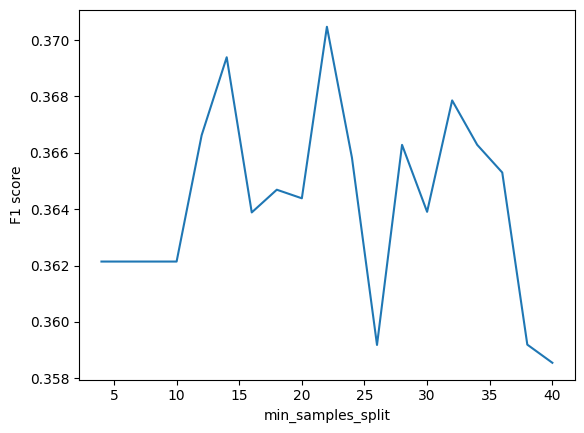

In [377]:
plt.plot(list(range(2, 41, 2)), np.mean(acur_split, axis=1))
plt.xlabel('min_samples_split')
plt.ylabel('F1 score')
plt.show()

### Logistic Regression

Now lets find parameters for logistic regression.

In [56]:
l1 = LogisticRegression(solver='saga', penalty='l1', max_iter=10000, n_jobs=-1)
l2 = LogisticRegression(solver='lbfgs', penalty='l2', max_iter=10000, n_jobs=-1)
params = {
    'C': np.logspace(-4, 4, 10)
}
lasso_CV = GridSearchCV(l1, params, cv=5, scoring='f1_weighted', n_jobs=-1)
ridge_CV = GridSearchCV(l2, params, cv=5, scoring='f1_weighted', n_jobs=-1)

In [57]:
lasso_CV.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=10000, n_jobs=-1,
                                          penalty='l1', solver='saga'),
             n_jobs=-1,
             param_grid={'C': array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04])},
             scoring='f1_weighted')

In [58]:
y_pred = lasso_CV.best_estimator_.predict(X_test)

print("Best params for lasso:", lasso_CV.best_params_)
print("Best score for lasso:", lasso_CV.best_score_)

print(f"Test result: {f1_score(y_test, y_pred, average='weighted'):.4f}")

Best params for lasso: {'C': 0.3593813663804626}
Best score for lasso: 0.4073444912198414
Test result: 0.4287


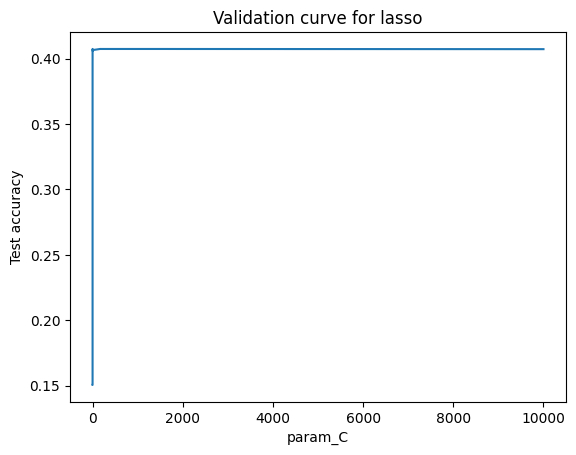

In [59]:
result = pd.DataFrame(lasso_CV.cv_results_)
plt.plot(result['param_C'], result['mean_test_score'])
plt.xlabel('param_C')
plt.ylabel('Test accuracy')
plt.title('Validation curve for lasso')
plt.show()

In [60]:
ridge_CV.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=10000, n_jobs=-1),
             n_jobs=-1,
             param_grid={'C': array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04])},
             scoring='f1_weighted')

In [61]:
y_pred = ridge_CV.best_estimator_.predict(X_test)

print("Best params for ridge:", ridge_CV.best_params_)
print("Best score for ridge:", ridge_CV.best_score_)

print(f"Test result: {f1_score(y_test, y_pred, average='weighted'):.4f}")

Best params for ridge: {'C': 0.3593813663804626}
Best score for ridge: 0.40641090882653524
Test result: 0.4376


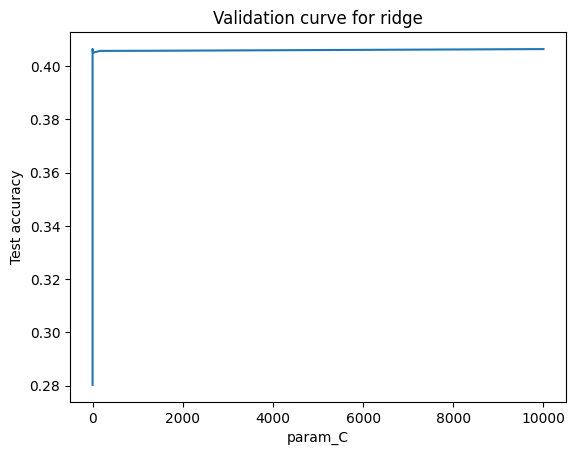

In [62]:
result = pd.DataFrame(ridge_CV.cv_results_)
plt.plot(result['param_C'], result['mean_test_score'])
plt.xlabel('param_C')
plt.ylabel('Test accuracy')
plt.title('Validation curve for ridge')
plt.show()

### Boosting

In [63]:
params_bg = { 'max_iter': list(range(21, 400, 30)) }
hgb_cl_CV = GridSearchCV(hgb, params_bg, cv=5, scoring='f1_weighted', n_jobs=-1)

In [64]:
hgb_cl_CV.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=HistGradientBoostingClassifier(), n_jobs=-1,
             param_grid={'max_iter': [21, 51, 81, 111, 141, 171, 201, 231, 261,
                                      291, 321, 351, 381]},
             scoring='f1_weighted')

In [65]:
y_pred = hgb_cl_CV.best_estimator_.predict(X_test)

print("Best params for ridge:", hgb_cl_CV.best_params_)
print("Best score for ridge:", hgb_cl_CV.best_score_)

print(f"Test result: {f1_score(y_test, y_pred, average='weighted'):.4f}")

Best params for ridge: {'max_iter': 381}
Best score for ridge: 0.37586537452377
Test result: 0.3815


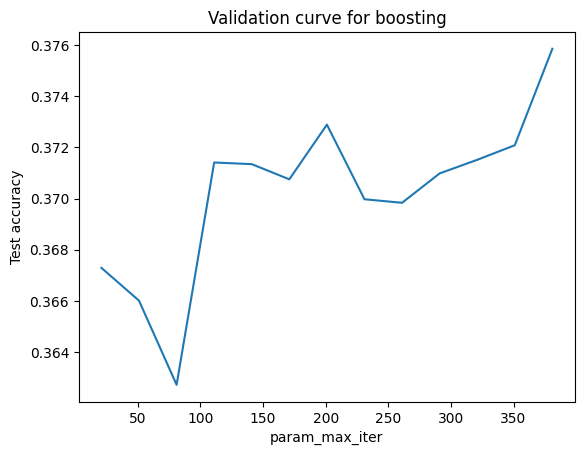

In [73]:
result = pd.DataFrame(hgb_cl_CV.cv_results_)
plt.plot(result['param_max_iter'], result['mean_test_score'])
plt.xlabel('param_max_iter')
plt.ylabel('Test accuracy')
plt.title('Validation curve for boosting')
plt.show()

### Bagging

In [74]:
params_bg = { 'n_estimators': list(range(21, 400, 30)) }
bg_cl_CV = GridSearchCV(bglr, params_bg, cv=5, scoring='f1_weighted', n_jobs=-1)

In [75]:
bg_cl_CV.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=BaggingClassifier(estimator=LogisticRegression(max_iter=4000,
                                                                      random_state=52),
                                         max_samples=0.5, n_jobs=-1),
             n_jobs=-1,
             param_grid={'n_estimators': [21, 51, 81, 111, 141, 171, 201, 231,
                                          261, 291, 321, 351, 381]},
             scoring='f1_weighted')

In [76]:
y_pred = bg_cl_CV.best_estimator_.predict(X_test)

print("Best params for ridge:", bg_cl_CV.best_params_)
print("Best score for ridge:", bg_cl_CV.best_score_)

print(f"Test result: {f1_score(y_test, y_pred, average='weighted'):.4f}")

Best params for ridge: {'n_estimators': 141}
Best score for ridge: 0.40818550361737793
Test result: 0.4306


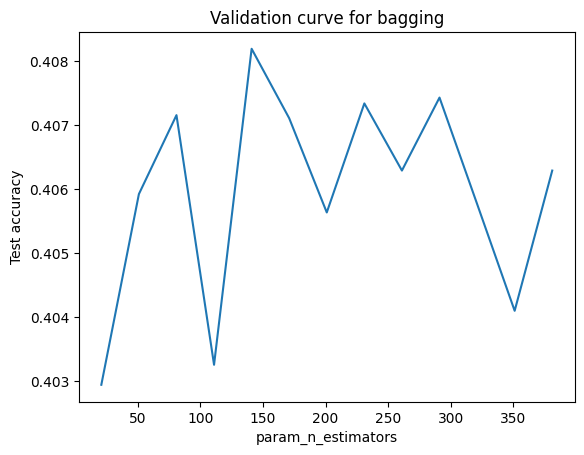

In [77]:
result = pd.DataFrame(bg_cl_CV.cv_results_)
plt.plot(result['param_n_estimators'], result['mean_test_score'])
plt.xlabel('param_n_estimators')
plt.ylabel('Test accuracy')
plt.title('Validation curve for bagging')
plt.show()

Conclusion: Surprisingly, our best performing model is logistic regression. It's probably because we used PCA that use linear model to decrease dimension.